Run this piece of code to get the necessary word embeddings txt used for the models.

In [1]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-12-14 11:19:54--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-14 11:19:54--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.03MB/s    in 2m 40s  

2021-12-14 11:22:35 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import *
import torch.nn as nn
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer

This code block reads the vaccine data and cleans the datasets like I did in HW1. It get's rid of #,:,.,'' and links. After that it open's the glove word embeddings and sets up a dictionary in which if you call emmbed_dict[word] it gives you the vector for that word. Tha vaccine data must be in a folder named 'data' and be uploaded in google collab. If you change the file name you can use another dataset for a testset.

In [5]:
#dataset and variables initialization
fields = ['tweet', 'label']
trainset = pd.read_csv("/content/data/vaccine_train_set.csv", usecols=fields)
testset = pd.read_csv("/content/data/vaccine_validation_set.csv", usecols=fields)
X_train = []
Y_train = []
X_train = trainset.tweet
Y_train = trainset.label
X_test = []
Y_test = []
X_test = testset.tweet
Y_test = testset.label

#nltk stopwords and punctuation datasets download
nltk.download('stopwords')
nltk.download('punkt')

#data cleaning
def clean_data(dataset):
    stop_words = set(stopwords.words('english'))
    #adding symbols we dont need in the stop words because the tokenizer tokenizes them alone anyway
    stop_words.add(":")
    stop_words.add("@")
    stop_words.add("#")
    stop_words.add(",")
    stop_words.add(".")
    stop_words.add("\'\'")
    new_dataset = []
    for row in dataset:
      dataset_tokens = word_tokenize(row)
      filtered = ""
      for w in dataset_tokens:
        #filtering stop_words and weird symbols (see above), removing the http word and removing links
        if (w not in stop_words) and ("http" not in w) and ("/" not in w ):
          filtered = filtered + " " + w
      new_dataset.append(filtered)
    return new_dataset
X_train = clean_data(X_train)
X_test = clean_data(X_test)

#setup word embeddings dictionary with the words as keys
emmbed_dict = {}
with open('/content//glove.6B.300d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


This function takes the cleaned datasets and tranform each sentence to a vector with the dimension of the downloaded word embeddings file dimension (In my programm I used the 300d one). Also if a word has capital letters it makes them lowercase because I figured out that the word emmbedings file has every word in lowercase. If a word does'nt appear in the word emmbedigs dictionary It get's skipped and it's dimensions does not add up to the sum that It eventually get's the average from. Every sentence becomes a vector of length 300 by averaging each sentence's word i'th dimension with i from 0 to 299. So after this procedure both train and validation datasets has the same 2nd dimension.

In [6]:
def words2vec(dataset):
    new_dataset = []
    for row in dataset:
      dataset_tokens = word_tokenize(row)
      vector = []
      #for each word dimension
      for i in range(len(emmbed_dict["word"])):
        sum = 0
        #calculate all sentence's words i'th dimension sum
        for w in dataset_tokens:
          if(w not in emmbed_dict):
            #lowercase the word because glove has every word in lowercase
            w = w.lower()
            #if a word does not exist in the word embeddings we continue to the next
            if(w not in emmbed_dict):
              continue
          sum = sum+emmbed_dict.get(w)[i]
        #append vector with their average
        vector.append(sum/len(dataset_tokens))
      new_dataset.append(vector)
    #the final value will be a [1][50] vector so all sentences of the dataset will have the same dimension
    return new_dataset
X_train_vec = words2vec(X_train)
X_test_vec = words2vec(X_test)

Here we transform the vectorized datasets to tensors.

In [7]:
x = torch.tensor(X_train_vec, dtype=torch.float)
x_test = torch.tensor(X_test_vec, dtype=torch.float)
y = torch.tensor(Y_train, dtype=torch.float)
yy_test = torch.tensor(Y_test, dtype=torch.float)
yy_test = yy_test.type(torch.LongTensor)
y = y.type(torch.LongTensor)
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: torch.Size([15976, 300])
y shape: torch.Size([15976])


This function get's the X and Y of a dataset, a model and a loss function and calculates the model's accuracy score,f1,precision and loss for that dataset applied to the given model. The last returned argument is the model's predictions returned raw because it is used for plotting the ROC curves later. The for loop takes the class with the most score from the predictions and makes an array with them so we can calculate the scores easier by using two [n][1] arrays


In [8]:
def get_ScoreAndLoss(ts,y_testset,my_model,LossFunc):
  with torch.no_grad():
    my_model.eval()
    #predictions
    y_pred_t = my_model(ts)
    y_final = []

    #take the max of the 3 outputs and append y_final with the correct label (0,1,2) 
    #which will be compared with the real labels to calculate score
    for i in range(len(y_pred_t)):
      if(max(y_pred_t[i]) == y_pred_t[i][0]):
        y_final.append(0)
      elif(max(y_pred_t[i]) == y_pred_t[i][1]):
        y_final.append(1)
      else:
        y_final.append(2)
    
    #calculate scores
    confm=confusion_matrix(y_testset, y_final)
    score = ((int)(confm[0][0] + confm[1][1] +confm[2][2])/len(y_testset))
    f1 = f1_score(y_testset, y_final, average='weighted')
    rec = recall_score(y_testset, y_final, average='weighted')
    prec = precision_score(y_testset, y_final, average='weighted',zero_division=0)

    #calculate loss
    y_testset_tensor = y_testset.clone().detach()
    y_testset_tensor = y_testset_tensor.type(torch.LongTensor)
    loss = LossFunc(y_pred_t,y_testset_tensor)
  return score,loss.item(),f1,rec,prec,y_pred_t

This is the first model using Tanh as activation function and a sigmoid just before the output. It also uses dropouts to help with the overfitting (checkthe exercise's documentation) and batch normalization at each layer to avoid gradients false behavior. It has 4 hidden layers with 256,128,64 and 32 nodes accordingly. CrossEntropyLoss and RAdam optimizers are used in both models because I concluded that they are the best for this kind of problem (check documentation). I used to have a softmax at the output but pyTorch's CrossEntropyLoss uses a softmax function anyway (I learned that later) so it would be an overkill to use a second one. This model uses 400 as batch size for training.

In [22]:
class Net(nn.Module):
    def __init__(self, num_feature,H0, H1, H2, H3, num_class):
        super(Net, self).__init__()
        
        self.l1 = nn.Linear(num_feature, H0)
        self.l2 = nn.Linear(H0, H1)
        self.l3 = nn.Linear(H1, H2)
        self.l4 = nn.Linear(H2, H3)
        self.lout = nn.Linear(H3, num_class) 
        
        self.tan = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        #self.soft = nn.Softmax(dim = 1)
        self.drop1 = nn.Dropout(p=0.3)
        self.drop2 = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(H0)
        self.batchnorm2 = nn.BatchNorm1d(H1)
        self.batchnorm3 = nn.BatchNorm1d(H2)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.batchnorm1(x)
        x = self.tan(x)
        x = self.drop1(x)

        x = self.l2(x)
        x = self.batchnorm2(x)
        x = self.tan(x)
        x = self.drop2(x)
        
        x = self.l3(x)
        x = self.batchnorm3(x)

        x=self.tan(x)
        x=self.l4(x)
        x = self.sigmoid(x)
        x = self.drop2(x)
        
        x = self.lout(x)
        #no softmax cause we use CrossEntropyLoss
        #x = self.soft(x)
        
        return x

#Define layer sizes
D_in = len(X_train_vec[0])
HL0 = 256
HL1 = 128
HL2 = 64
HL3 = 32
D_out = 3

#Define Hyperparameters
learning_rate = 9e-4

#Initialize model, loss, optimizer
classes=3
model = Net(D_in, HL0, HL1, HL2 ,HL3 ,D_out)
k = torch.ones(classes, dtype=torch.float32)
loss_func = nn.CrossEntropyLoss(weight=k ,reduction='mean')
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)

#Initialize dataloader
dataset = torch.utils.data.TensorDataset(x, y)

#batch size hyperparameter defined here
dataloader = torch.utils.data.DataLoader(dataset, batch_size=400, shuffle=True)

Model training as we saw it in the class with the addition that at every epoch the model evaluates itself in the validation set. Those scores and curves are shown later.

In [23]:
#Train model 1 (Tanh model)
scores_epoch_avg = []
train_losses_per_epoch = []
test_losses = []
test_scores = []
roc_scores = []
for epoch in range(50):
  model.train()
  batch_losses = []

  for x_batch, y_batch in dataloader:
    y_pred = model(x_batch)
    scores = []
    y_final = []
    #This for loop is the same as in the 'get_ScoreAndLoss' function presented above
    for i in range(len(y_pred)):
      if(max(y_pred[i]) == y_pred[i][0]):
        y_final.append(0)
      elif(max(y_pred[i]) == y_pred[i][1]):
        y_final.append(1)
      else:
        y_final.append(2)

    loss = loss_func(y_pred, y_batch)
    batch_losses.append(loss.item())
    
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

    scores.append(f1_score(y_batch, y_final, average='weighted'))

  scores_epoch_avg.append(sum(scores)/len(scores))
  train_losses_per_epoch.append(sum(batch_losses)/len(dataloader))

  #model evaluation
  #get_ScoreAndLoss returns accuracy,loss,f1,recall,precision
  _ , test_loss, test_score , _ , _ , roc_score= get_ScoreAndLoss(x_test,yy_test,model,loss_func)
  test_scores.append(test_score)
  test_losses.append(test_loss)
  roc_scores.append(roc_score)

  print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(dataloader):.5f}")

Epoch   0: Loss = 1.02636
Epoch   1: Loss = 0.95455
Epoch   2: Loss = 0.87980
Epoch   3: Loss = 0.82657
Epoch   4: Loss = 0.79164
Epoch   5: Loss = 0.76884
Epoch   6: Loss = 0.75536
Epoch   7: Loss = 0.73927
Epoch   8: Loss = 0.72808
Epoch   9: Loss = 0.72299
Epoch  10: Loss = 0.71142
Epoch  11: Loss = 0.69991
Epoch  12: Loss = 0.69442
Epoch  13: Loss = 0.68790
Epoch  14: Loss = 0.67364
Epoch  15: Loss = 0.66641
Epoch  16: Loss = 0.66077
Epoch  17: Loss = 0.64904
Epoch  18: Loss = 0.64826
Epoch  19: Loss = 0.63396
Epoch  20: Loss = 0.63770
Epoch  21: Loss = 0.62598
Epoch  22: Loss = 0.61486
Epoch  23: Loss = 0.61124
Epoch  24: Loss = 0.60243
Epoch  25: Loss = 0.59897
Epoch  26: Loss = 0.58777
Epoch  27: Loss = 0.57910
Epoch  28: Loss = 0.58071
Epoch  29: Loss = 0.56973
Epoch  30: Loss = 0.56336
Epoch  31: Loss = 0.55731
Epoch  32: Loss = 0.54703
Epoch  33: Loss = 0.53747
Epoch  34: Loss = 0.53755
Epoch  35: Loss = 0.52986
Epoch  36: Loss = 0.52287
Epoch  37: Loss = 0.51076
Epoch  38: L

This is the second model which uses PReLU and it is the better model of the 2 and the best model I came up in this exercise. It has also 4 hidden layers but with 125,125,75 and 30 nodes accordingly. It also has a learning rate of 2e-4 instead of 9e-4 in the other model and uses a batch size of 450.

In [20]:
class Net2(nn.Module):
    def __init__(self, num_feature,H0, H1, H2, H3, num_class):
        super(Net2, self).__init__()
        
        self.l1 = nn.Linear(num_feature, H0)
        self.l2 = nn.Linear(H0, H1)
        self.l3 = nn.Linear(H1, H2)
        self.l4 = nn.Linear(H2, H3)
        self.lout = nn.Linear(H3, num_class) 
        
        self.relu = nn.PReLU()
        self.sigmoid = nn.Sigmoid()
        self.drop1 = nn.Dropout(p=0.3)
        self.drop2 = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(H0)
        self.batchnorm2 = nn.BatchNorm1d(H1)
        self.batchnorm3 = nn.BatchNorm1d(H2)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.drop1(x)

        x = self.l2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.drop2(x)
        
        x = self.l3(x)
        x = self.batchnorm3(x)

        x=self.relu(x)
        x=self.l4(x)
        x = self.sigmoid(x)
        x = self.drop2(x)
        
        x = self.lout(x)
        
        return x

#Define layer sizes
D_in = len(X_train_vec[0])
HL0 = 125
HL1 = 125
HL2 = 75
HL3 = 30
D_out = 3

learning_rate_2 = 2e-4

classes = 3
model_2 = Net2(D_in, HL0, HL1, HL2 ,HL3 ,D_out)
k = torch.ones(classes, dtype=torch.float32)
loss_func_2 = nn.CrossEntropyLoss(weight=k ,reduction='mean')
optimizer_2 = torch.optim.RAdam(model_2.parameters(), lr=learning_rate_2)

dataset_2 = torch.utils.data.TensorDataset(x, y)

dataloader_2 = torch.utils.data.DataLoader(dataset, batch_size=450, shuffle=True)

Same training process as in model 1.

In [21]:
#Train model 2 (Prelu model)
scores_epoch_avg_2 = []
train_losses_per_epoch_2 = []
test_losses_2 = []
test_scores_2 = []
roc_scores_2 = []
for epoch in range(50):
  model_2.train()
  batch_losses = []

  for x_batch, y_batch in dataloader_2:
    y_pred = model_2(x_batch)
    scores = []
    y_final = []
    for i in range(len(y_pred)):
      if(max(y_pred[i]) == y_pred[i][0]):
        y_final.append(0)
      elif(max(y_pred[i]) == y_pred[i][1]):
        y_final.append(1)
      else:
        y_final.append(2)

    loss = loss_func_2(y_pred, y_batch)
    batch_losses.append(loss.item())
    

    optimizer_2.zero_grad()

    loss.backward()

    optimizer_2.step()

    scores.append(f1_score(y_batch, y_final, average='weighted'))

  scores_epoch_avg_2.append(sum(scores)/len(scores))
  train_losses_per_epoch_2.append(sum(batch_losses)/len(dataloader_2))

  _ , test_loss, test_score , _ , _ , roc_score= get_ScoreAndLoss(x_test,yy_test,model_2,loss_func_2)
  test_scores_2.append(test_score)
  test_losses_2.append(test_loss)
  roc_scores_2.append(roc_score)

  print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(dataloader_2):.5f}")

Epoch   0: Loss = 1.15575
Epoch   1: Loss = 1.13638
Epoch   2: Loss = 1.11162
Epoch   3: Loss = 1.08240
Epoch   4: Loss = 1.05013
Epoch   5: Loss = 1.01980
Epoch   6: Loss = 0.98942
Epoch   7: Loss = 0.96195
Epoch   8: Loss = 0.93475
Epoch   9: Loss = 0.91051
Epoch  10: Loss = 0.89087
Epoch  11: Loss = 0.86930
Epoch  12: Loss = 0.85025
Epoch  13: Loss = 0.83651
Epoch  14: Loss = 0.81908
Epoch  15: Loss = 0.80776
Epoch  16: Loss = 0.79324
Epoch  17: Loss = 0.78181
Epoch  18: Loss = 0.77217
Epoch  19: Loss = 0.76024
Epoch  20: Loss = 0.75054
Epoch  21: Loss = 0.74545
Epoch  22: Loss = 0.73618
Epoch  23: Loss = 0.72998
Epoch  24: Loss = 0.72386
Epoch  25: Loss = 0.71341
Epoch  26: Loss = 0.71226
Epoch  27: Loss = 0.70440
Epoch  28: Loss = 0.70021
Epoch  29: Loss = 0.69649
Epoch  30: Loss = 0.69064
Epoch  31: Loss = 0.68587
Epoch  32: Loss = 0.68322
Epoch  33: Loss = 0.67862
Epoch  34: Loss = 0.67408
Epoch  35: Loss = 0.67043
Epoch  36: Loss = 0.66573
Epoch  37: Loss = 0.65741
Epoch  38: L

This cell calculates scores on the validation set after both trainings and prints them to see their final performance.

In [24]:
  print("Model 1 (Tanh) scores:\n")
  sc , los, f1, rec, prec, _ = get_ScoreAndLoss(x_test,yy_test,model,loss_func)
  print("Test Accuracy Score: ", end = '')
  print(sc*100)
  print("Test F1 Score: ", end = '')
  print(f1*100)
  print("Test Recall Score: ", end = '')
  print(rec*100)
  print("Test Precision Score: ", end = '')
  print(prec*100)
  print("Test Loss: ", end = '')
  print(los)
  print("\n--------------------------------------------------------------------\n")
  print("Model 2 (PReLU) scores:\n")
  sc , los, f1, rec, prec, _ = get_ScoreAndLoss(x_test,yy_test,model_2,loss_func_2)
  print("Test Accuracy Score: ", end = '')
  print(sc*100)
  print("Test F1 Score: ", end = '')
  print(f1*100)
  print("Test Recall Score: ", end = '')
  print(rec*100)
  print("Test Precision Score: ", end = '')
  print(prec*100)
  print("Test Loss: ", end = '')
  print(los)

Model 1 (Tanh) scores:

Test Accuracy Score: 70.72743207712533
Test F1 Score: 70.22324182229369
Test Recall Score: 70.72743207712533
Test Precision Score: 70.08649988084046
Test Loss: 0.7775620222091675

--------------------------------------------------------------------

Model 2 (PReLU) scores:

Test Accuracy Score: 71.47239263803681
Test F1 Score: 71.22609471836275
Test Recall Score: 71.47239263803681
Test Precision Score: 71.74890793334754
Test Loss: 0.6767627000808716


This function plots the learning curves which are f1_score per epoch and loss per epoch in our situation. It takes the losses,scores etc. ready to go and just makes the plotting.

In [25]:
#plot curves
def plot_learning_curves(train_losses, train_scores, test_losses, test_scores, axes, ylim_score, ylim_loss, title):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_ylim(*ylim_score)
    axes[1].set_ylim(*ylim_loss)
    
    axes[0].set_xlabel("Epochs")
    axes[1].set_xlabel("Epochs")
    axes[0].set_ylabel("f1 Score")
    axes[1].set_ylabel("Losses")

    axes[0].set_title(title + " Score per Epoch")
    axes[0].grid()
    axes[0].plot(
        train_scores, color="orange", label="Train"
    )
    axes[0].plot(
        test_scores, color="blue", label="Valid"
    )

    axes[1].set_title(title + "Losses per epoch")
    axes[1].grid()
    axes[1].plot(
        train_losses, color="orange", label="Train"
    )
    axes[1].plot(
        test_losses, color="blue", label="Valid"
    )
    axes[0].legend(loc="best")
    axes[1].legend(loc="best")
    return plt

This cell makes the curves for model 1 (Tanh model) by calling the above function.

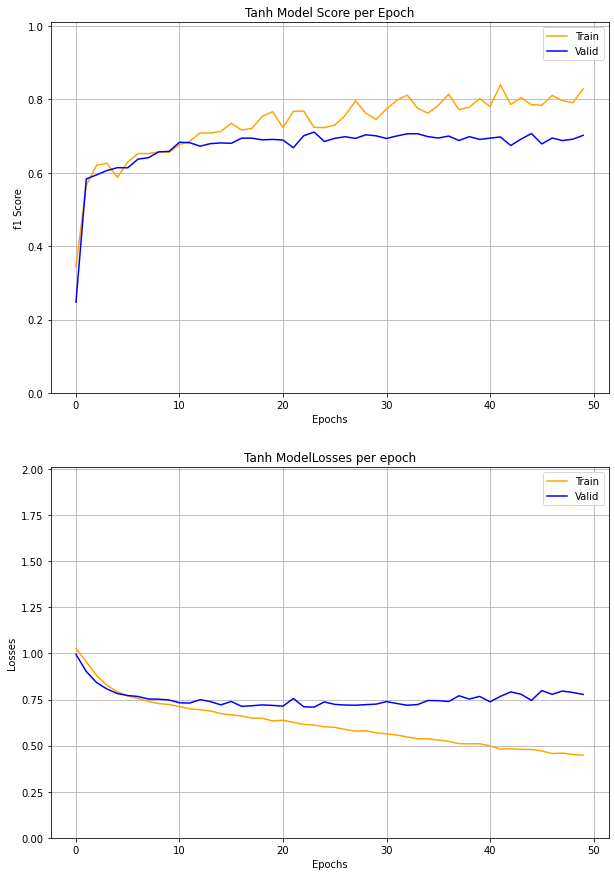

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

plot_learning_curves(
    train_losses_per_epoch, scores_epoch_avg, test_losses, test_scores, axes=axes, ylim_score=(0, 1.01), ylim_loss=(0,2.01), title = "Tanh Model"
)
plt.show()

This cell makes the curves for model 2 (PReLU model).

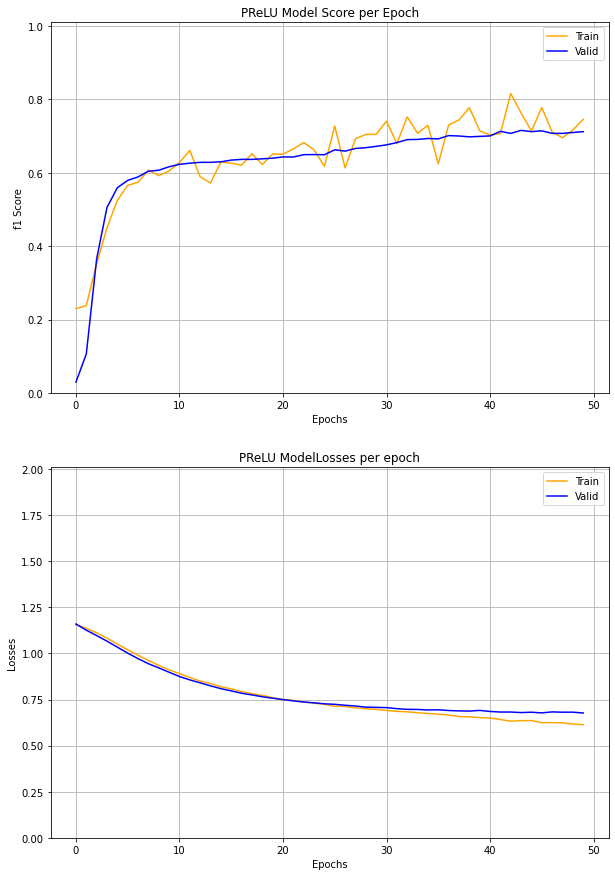

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

plot_learning_curves(
    train_losses_per_epoch_2, scores_epoch_avg_2, test_losses_2, test_scores_2, axes=axes, ylim_score=(0, 1.01), ylim_loss=(0,2.01), title = "PReLU Model"
)
plt.show()

This is the same function that sk learn has for plotting the ROC curves with the only difference I give the y_test and y_score arrays already calculated so I removed the piece of code that trains a model. The y_test gets binarized because we have 3 classes and it needs to be like that for the curves to be plotted. The y_score is an array [n][samples][3] where the samples are the validation set's sentences, n is the number of epochs and 3 are the propabilities of each sentence to belong to a specific class (0, 1, 2). 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plt_roc(y_t, y_s, title):
  y_test = y_t
  y_score = y_s
  #binarize testset labels because it is needed for multilabel classficiation ROC
  y_test = label_binarize(y_test, classes=[0, 1, 2])
  n_classes = y_test.shape[1]
  #Get the computed predicted scores on the test set of the last epoch
  y_score = y_s[len(y_s)-1]

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Plot of a ROC curve for a specific class
  plt.figure()
  plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title + " ROC Curve")
  plt.legend(loc="lower right")
  plt.show()

  # Plot ROC curve
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]))
  for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                    ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

Run this code cell to generate ROC curves for model 1 (Tanh Model).

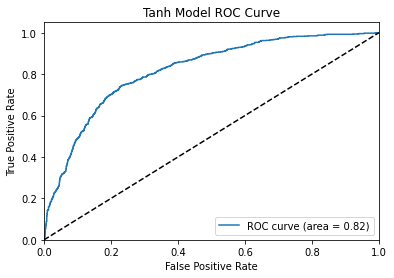

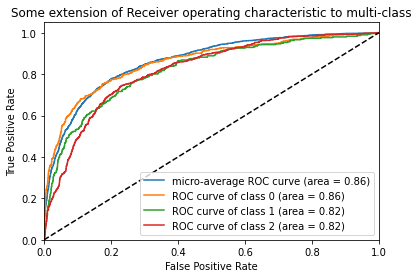

In [29]:
#Plot roc for model 1 (Tanh model)
plt_roc(yy_test, roc_scores, "Tanh Model")

Run this code cell to generate ROC curves for model 2 (PReLU model).

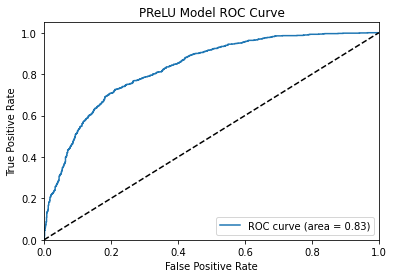

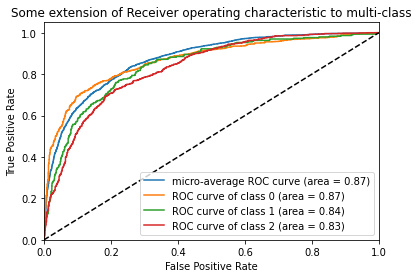

In [30]:
#Plot roc for model 2 (PReLU model)
plt_roc(yy_test, roc_scores_2, "PReLU Model")